# PROJECT 20 - Segmentation map 으로 도로 이미지 만들기

도로의 레이블 정보 데이터 셋을 이용해 Pix2Pix를 학습시켜 이미지를 생성합니다.

## 프로젝트 필수 사항
1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.
(어떠한 방법을 사용했는지 적어주세요.)
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

## 1. 데이터 준비하기
1000개의 학습 이미지 및 5개의 평가 이미지를 포함하는 도로의 레이블 데이터셋입니다.

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'

print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


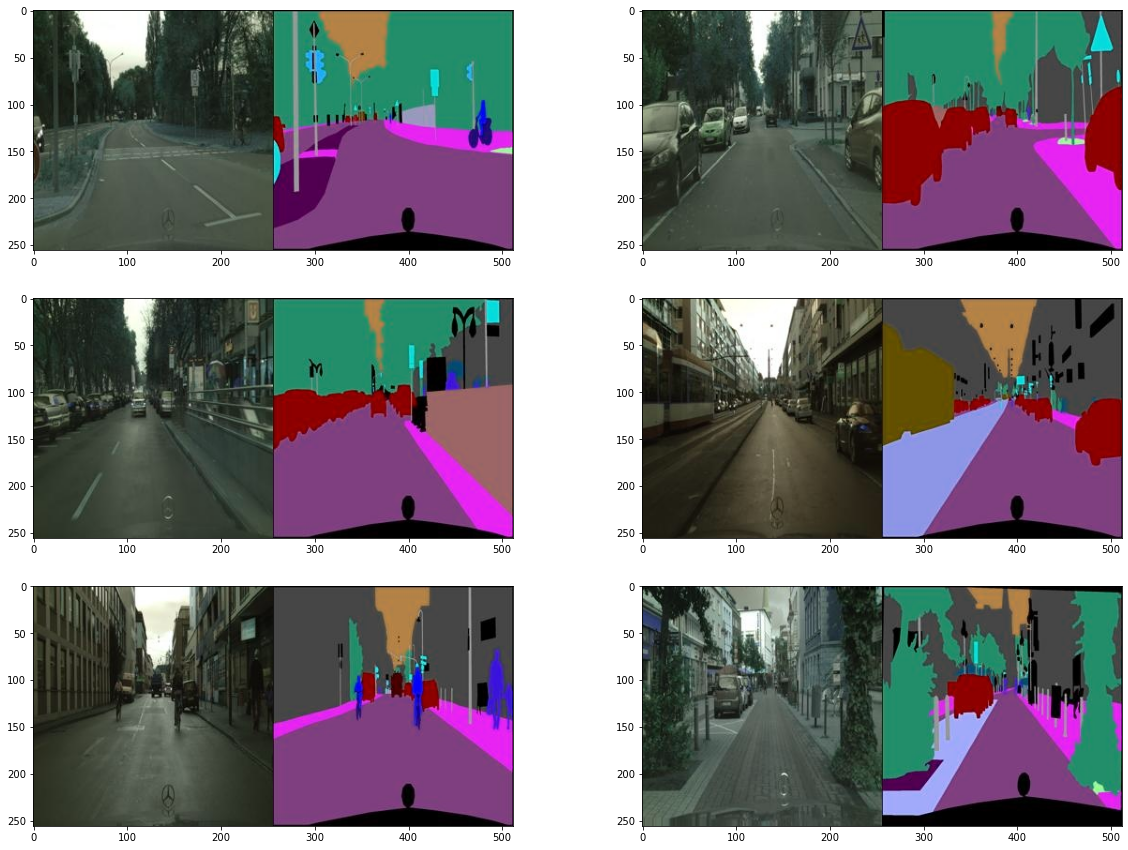

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


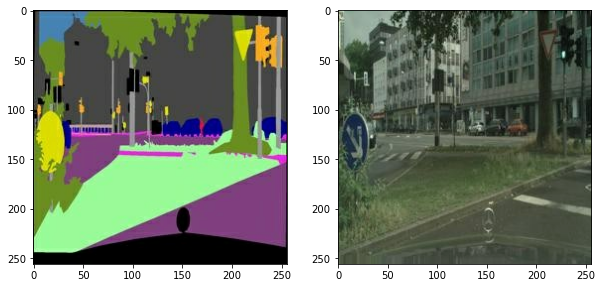

In [7]:
# 두개의 이미지로 나누기
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [8]:
# augmentation 방법 적용
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

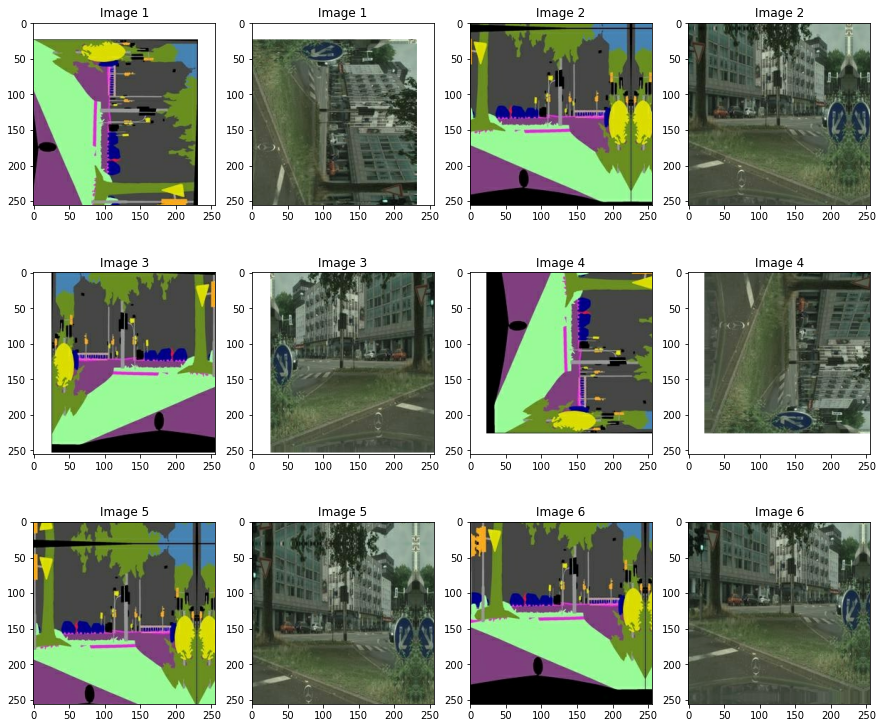

In [9]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

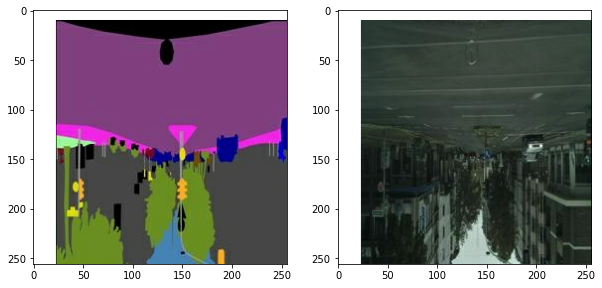

In [10]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(8)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 2. Generator 구성하기

In [11]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [12]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [13]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [14]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [15]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [16]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [17]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

## 3. Discriminator 구성하기

In [18]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [19]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [20]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [21]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

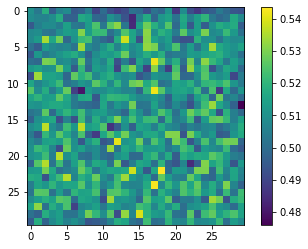

In [22]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 4. 학습 및 테스트하기

In [23]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [24]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [25]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [26]:
EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")


EPOCH[1] - STEP[10]                     
Generator_loss:1.0323                     
L1_loss:0.3227                     
Discriminator_loss:1.3400

EPOCH[1] - STEP[20]                     
Generator_loss:1.0027                     
L1_loss:0.2215                     
Discriminator_loss:1.2489

EPOCH[1] - STEP[30]                     
Generator_loss:1.0388                     
L1_loss:0.1673                     
Discriminator_loss:1.2867

EPOCH[1] - STEP[40]                     
Generator_loss:0.9353                     
L1_loss:0.1823                     
Discriminator_loss:1.1501

EPOCH[1] - STEP[50]                     
Generator_loss:0.8123                     
L1_loss:0.2271                     
Discriminator_loss:1.0846

EPOCH[1] - STEP[60]                     
Generator_loss:0.8635                     
L1_loss:0.1822                     
Discriminator_loss:1.1280

EPOCH[1] - STEP[70]                     
Generator_loss:1.1346                     
L1_loss:0.1666                    

EPOCH[5] - STEP[90]                     
Generator_loss:1.8486                     
L1_loss:0.1706                     
Discriminator_loss:0.5686

EPOCH[5] - STEP[100]                     
Generator_loss:0.8441                     
L1_loss:0.1844                     
Discriminator_loss:1.0440

EPOCH[5] - STEP[110]                     
Generator_loss:2.5603                     
L1_loss:0.1947                     
Discriminator_loss:0.6828

EPOCH[5] - STEP[120]                     
Generator_loss:0.7733                     
L1_loss:0.1998                     
Discriminator_loss:0.8119

EPOCH[6] - STEP[10]                     
Generator_loss:1.2766                     
L1_loss:0.1970                     
Discriminator_loss:0.5425

EPOCH[6] - STEP[20]                     
Generator_loss:1.3205                     
L1_loss:0.2002                     
Discriminator_loss:0.4964

EPOCH[6] - STEP[30]                     
Generator_loss:1.4715                     
L1_loss:0.2077                 

EPOCH[10] - STEP[50]                     
Generator_loss:1.7433                     
L1_loss:0.1905                     
Discriminator_loss:0.6889

EPOCH[10] - STEP[60]                     
Generator_loss:1.7767                     
L1_loss:0.1784                     
Discriminator_loss:0.6719

EPOCH[10] - STEP[70]                     
Generator_loss:2.0231                     
L1_loss:0.1873                     
Discriminator_loss:0.5051

EPOCH[10] - STEP[80]                     
Generator_loss:3.3407                     
L1_loss:0.1623                     
Discriminator_loss:1.5403

EPOCH[10] - STEP[90]                     
Generator_loss:1.3152                     
L1_loss:0.1897                     
Discriminator_loss:0.8191

EPOCH[10] - STEP[100]                     
Generator_loss:0.9406                     
L1_loss:0.1869                     
Discriminator_loss:1.4157

EPOCH[10] - STEP[110]                     
Generator_loss:1.4231                     
L1_loss:0.1752           

EPOCH[15] - STEP[10]                     
Generator_loss:1.8584                     
L1_loss:0.1774                     
Discriminator_loss:1.1682

EPOCH[15] - STEP[20]                     
Generator_loss:0.4495                     
L1_loss:0.1943                     
Discriminator_loss:1.1558

EPOCH[15] - STEP[30]                     
Generator_loss:1.4456                     
L1_loss:0.1720                     
Discriminator_loss:0.7450

EPOCH[15] - STEP[40]                     
Generator_loss:2.1935                     
L1_loss:0.1737                     
Discriminator_loss:0.6241

EPOCH[15] - STEP[50]                     
Generator_loss:0.7807                     
L1_loss:0.1631                     
Discriminator_loss:1.0387

EPOCH[15] - STEP[60]                     
Generator_loss:0.1365                     
L1_loss:0.1797                     
Discriminator_loss:2.3900

EPOCH[15] - STEP[70]                     
Generator_loss:1.6166                     
L1_loss:0.1592             

EPOCH[19] - STEP[90]                     
Generator_loss:1.8504                     
L1_loss:0.1649                     
Discriminator_loss:0.7998

EPOCH[19] - STEP[100]                     
Generator_loss:2.1691                     
L1_loss:0.1904                     
Discriminator_loss:1.2038

EPOCH[19] - STEP[110]                     
Generator_loss:1.0571                     
L1_loss:0.1775                     
Discriminator_loss:0.7760

EPOCH[19] - STEP[120]                     
Generator_loss:0.6219                     
L1_loss:0.1989                     
Discriminator_loss:0.9918

EPOCH[20] - STEP[10]                     
Generator_loss:2.4474                     
L1_loss:0.1645                     
Discriminator_loss:0.7027

EPOCH[20] - STEP[20]                     
Generator_loss:0.7401                     
L1_loss:0.1872                     
Discriminator_loss:0.9222

EPOCH[20] - STEP[30]                     
Generator_loss:0.5311                     
L1_loss:0.1846          

EPOCH[24] - STEP[50]                     
Generator_loss:1.5026                     
L1_loss:0.1811                     
Discriminator_loss:0.5064

EPOCH[24] - STEP[60]                     
Generator_loss:1.3567                     
L1_loss:0.2037                     
Discriminator_loss:0.5033

EPOCH[24] - STEP[70]                     
Generator_loss:1.6001                     
L1_loss:0.2005                     
Discriminator_loss:0.4271

EPOCH[24] - STEP[80]                     
Generator_loss:1.6527                     
L1_loss:0.1705                     
Discriminator_loss:1.4190

EPOCH[24] - STEP[90]                     
Generator_loss:0.4068                     
L1_loss:0.1532                     
Discriminator_loss:1.4546

EPOCH[24] - STEP[100]                     
Generator_loss:0.7666                     
L1_loss:0.1652                     
Discriminator_loss:1.3566

EPOCH[24] - STEP[110]                     
Generator_loss:2.0371                     
L1_loss:0.1744           

EPOCH[29] - STEP[10]                     
Generator_loss:1.0496                     
L1_loss:0.1868                     
Discriminator_loss:1.0370

EPOCH[29] - STEP[20]                     
Generator_loss:1.6078                     
L1_loss:0.1723                     
Discriminator_loss:0.2967

EPOCH[29] - STEP[30]                     
Generator_loss:0.8765                     
L1_loss:0.1788                     
Discriminator_loss:1.4618

EPOCH[29] - STEP[40]                     
Generator_loss:2.0237                     
L1_loss:0.1948                     
Discriminator_loss:0.8843

EPOCH[29] - STEP[50]                     
Generator_loss:0.4872                     
L1_loss:0.1977                     
Discriminator_loss:1.2357

EPOCH[29] - STEP[60]                     
Generator_loss:1.9580                     
L1_loss:0.1892                     
Discriminator_loss:0.4893

EPOCH[29] - STEP[70]                     
Generator_loss:0.8188                     
L1_loss:0.1767             

EPOCH[33] - STEP[90]                     
Generator_loss:1.1337                     
L1_loss:0.1714                     
Discriminator_loss:0.6271

EPOCH[33] - STEP[100]                     
Generator_loss:2.2035                     
L1_loss:0.1765                     
Discriminator_loss:0.5242

EPOCH[33] - STEP[110]                     
Generator_loss:0.5698                     
L1_loss:0.1715                     
Discriminator_loss:1.0545

EPOCH[33] - STEP[120]                     
Generator_loss:2.6167                     
L1_loss:0.1820                     
Discriminator_loss:2.9020

EPOCH[34] - STEP[10]                     
Generator_loss:1.9710                     
L1_loss:0.1789                     
Discriminator_loss:0.3495

EPOCH[34] - STEP[20]                     
Generator_loss:0.2871                     
L1_loss:0.1930                     
Discriminator_loss:1.7345

EPOCH[34] - STEP[30]                     
Generator_loss:1.9213                     
L1_loss:0.1836          

EPOCH[38] - STEP[50]                     
Generator_loss:0.6146                     
L1_loss:0.1936                     
Discriminator_loss:0.9348

EPOCH[38] - STEP[60]                     
Generator_loss:0.5325                     
L1_loss:0.1833                     
Discriminator_loss:1.0393

EPOCH[38] - STEP[70]                     
Generator_loss:2.3958                     
L1_loss:0.1659                     
Discriminator_loss:1.8633

EPOCH[38] - STEP[80]                     
Generator_loss:1.9099                     
L1_loss:0.1624                     
Discriminator_loss:1.9228

EPOCH[38] - STEP[90]                     
Generator_loss:1.5853                     
L1_loss:0.1820                     
Discriminator_loss:0.7633

EPOCH[38] - STEP[100]                     
Generator_loss:0.5453                     
L1_loss:0.1808                     
Discriminator_loss:1.1927

EPOCH[38] - STEP[110]                     
Generator_loss:0.9491                     
L1_loss:0.1946           

EPOCH[43] - STEP[10]                     
Generator_loss:0.6383                     
L1_loss:0.1814                     
Discriminator_loss:0.9308

EPOCH[43] - STEP[20]                     
Generator_loss:1.3634                     
L1_loss:0.1609                     
Discriminator_loss:0.6749

EPOCH[43] - STEP[30]                     
Generator_loss:1.8710                     
L1_loss:0.1841                     
Discriminator_loss:1.6287

EPOCH[43] - STEP[40]                     
Generator_loss:2.4363                     
L1_loss:0.1674                     
Discriminator_loss:1.1397

EPOCH[43] - STEP[50]                     
Generator_loss:2.9197                     
L1_loss:0.1684                     
Discriminator_loss:2.4903

EPOCH[43] - STEP[60]                     
Generator_loss:1.2544                     
L1_loss:0.1826                     
Discriminator_loss:0.9447

EPOCH[43] - STEP[70]                     
Generator_loss:0.6089                     
L1_loss:0.1801             

EPOCH[47] - STEP[90]                     
Generator_loss:1.2789                     
L1_loss:0.1682                     
Discriminator_loss:1.6205

EPOCH[47] - STEP[100]                     
Generator_loss:0.3032                     
L1_loss:0.2055                     
Discriminator_loss:1.7890

EPOCH[47] - STEP[110]                     
Generator_loss:1.1240                     
L1_loss:0.1824                     
Discriminator_loss:0.5661

EPOCH[47] - STEP[120]                     
Generator_loss:1.4362                     
L1_loss:0.1668                     
Discriminator_loss:0.6239

EPOCH[48] - STEP[10]                     
Generator_loss:2.4941                     
L1_loss:0.1814                     
Discriminator_loss:0.8653

EPOCH[48] - STEP[20]                     
Generator_loss:1.9527                     
L1_loss:0.2106                     
Discriminator_loss:0.2593

EPOCH[48] - STEP[30]                     
Generator_loss:0.7270                     
L1_loss:0.1784          

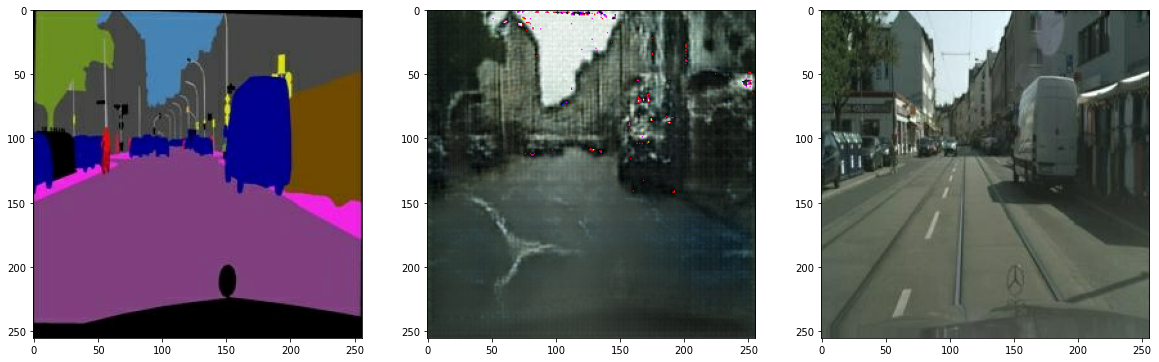

In [28]:
test_ind = 1

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'
f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

## [ 결과 - 루브릭 ]
**1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.**
- 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었습니다. :)  

**2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.** 
- U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였습니다. :)
  
**3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.**
- 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하지못하였습니다. :)